# Food Waste to Animal Feed

In [1]:
# Import libraries
from swolfpy_processmodels import AnF
from swolfpy_inputdata import AnF_Input

import swolfpy as sp
import swolfpy_inputdata as spid
import swolfpy_processmodels as sppm

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy_financial as npf

# Set font for plots
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "12"

from IPython.display import Image

# Set specs for pandas
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.precision', 2)

#### Animal Feed Model Input Data

In [2]:
input_data = AnF_Input()
data_df = input_data.Data
data_df.head()

,Category,Dictonary_Name,Parameter Name,Parameter Description,amount,unit,uncertainty_type,loc,scale,shape,minimum,maximum,Reference,Comment
0,AnF_operation,AnF_operation,ophrsperday,Daily operating hours,8.00,hours,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AnF_operation,AnF_operation,opdaysperyear,Annual operating days,260.00,days,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AnF_operation,AnF_operation,isDried,Dried Anima Feed? (0=no; 1=yes),0.00,0/1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AnF_operation,AnF_operation,Dew_moist,Moisture content after dewatering,0.50,mass water/total mass,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AnF_operation,AnF_operation,Dried_moist,Moisture content after drying,0.25,mass water/total mass,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Food Waste Properties

In [3]:
CommanData = spid.CommonData()
CommanData.Material_Properties.iloc[3:5, [0, 1, 2, 3, 7, 12, 13, 14]]

,Moisture Content,Volatile Solids,Ash Content,Lower Heating Value,Biogenic Carbon Content,Nitrogen Content,Phosphorus Content,Potassium Content
Food_Waste_Vegetable,78.3,95.1,4.89,18.6,49.1,1.68,0.23,1.27
Food_Waste_Non_Vegetable,70.6,94.0,6.00,18.9,48.4,2.94,1.00,0.53


#### Animal Feed Process Flow Diagram

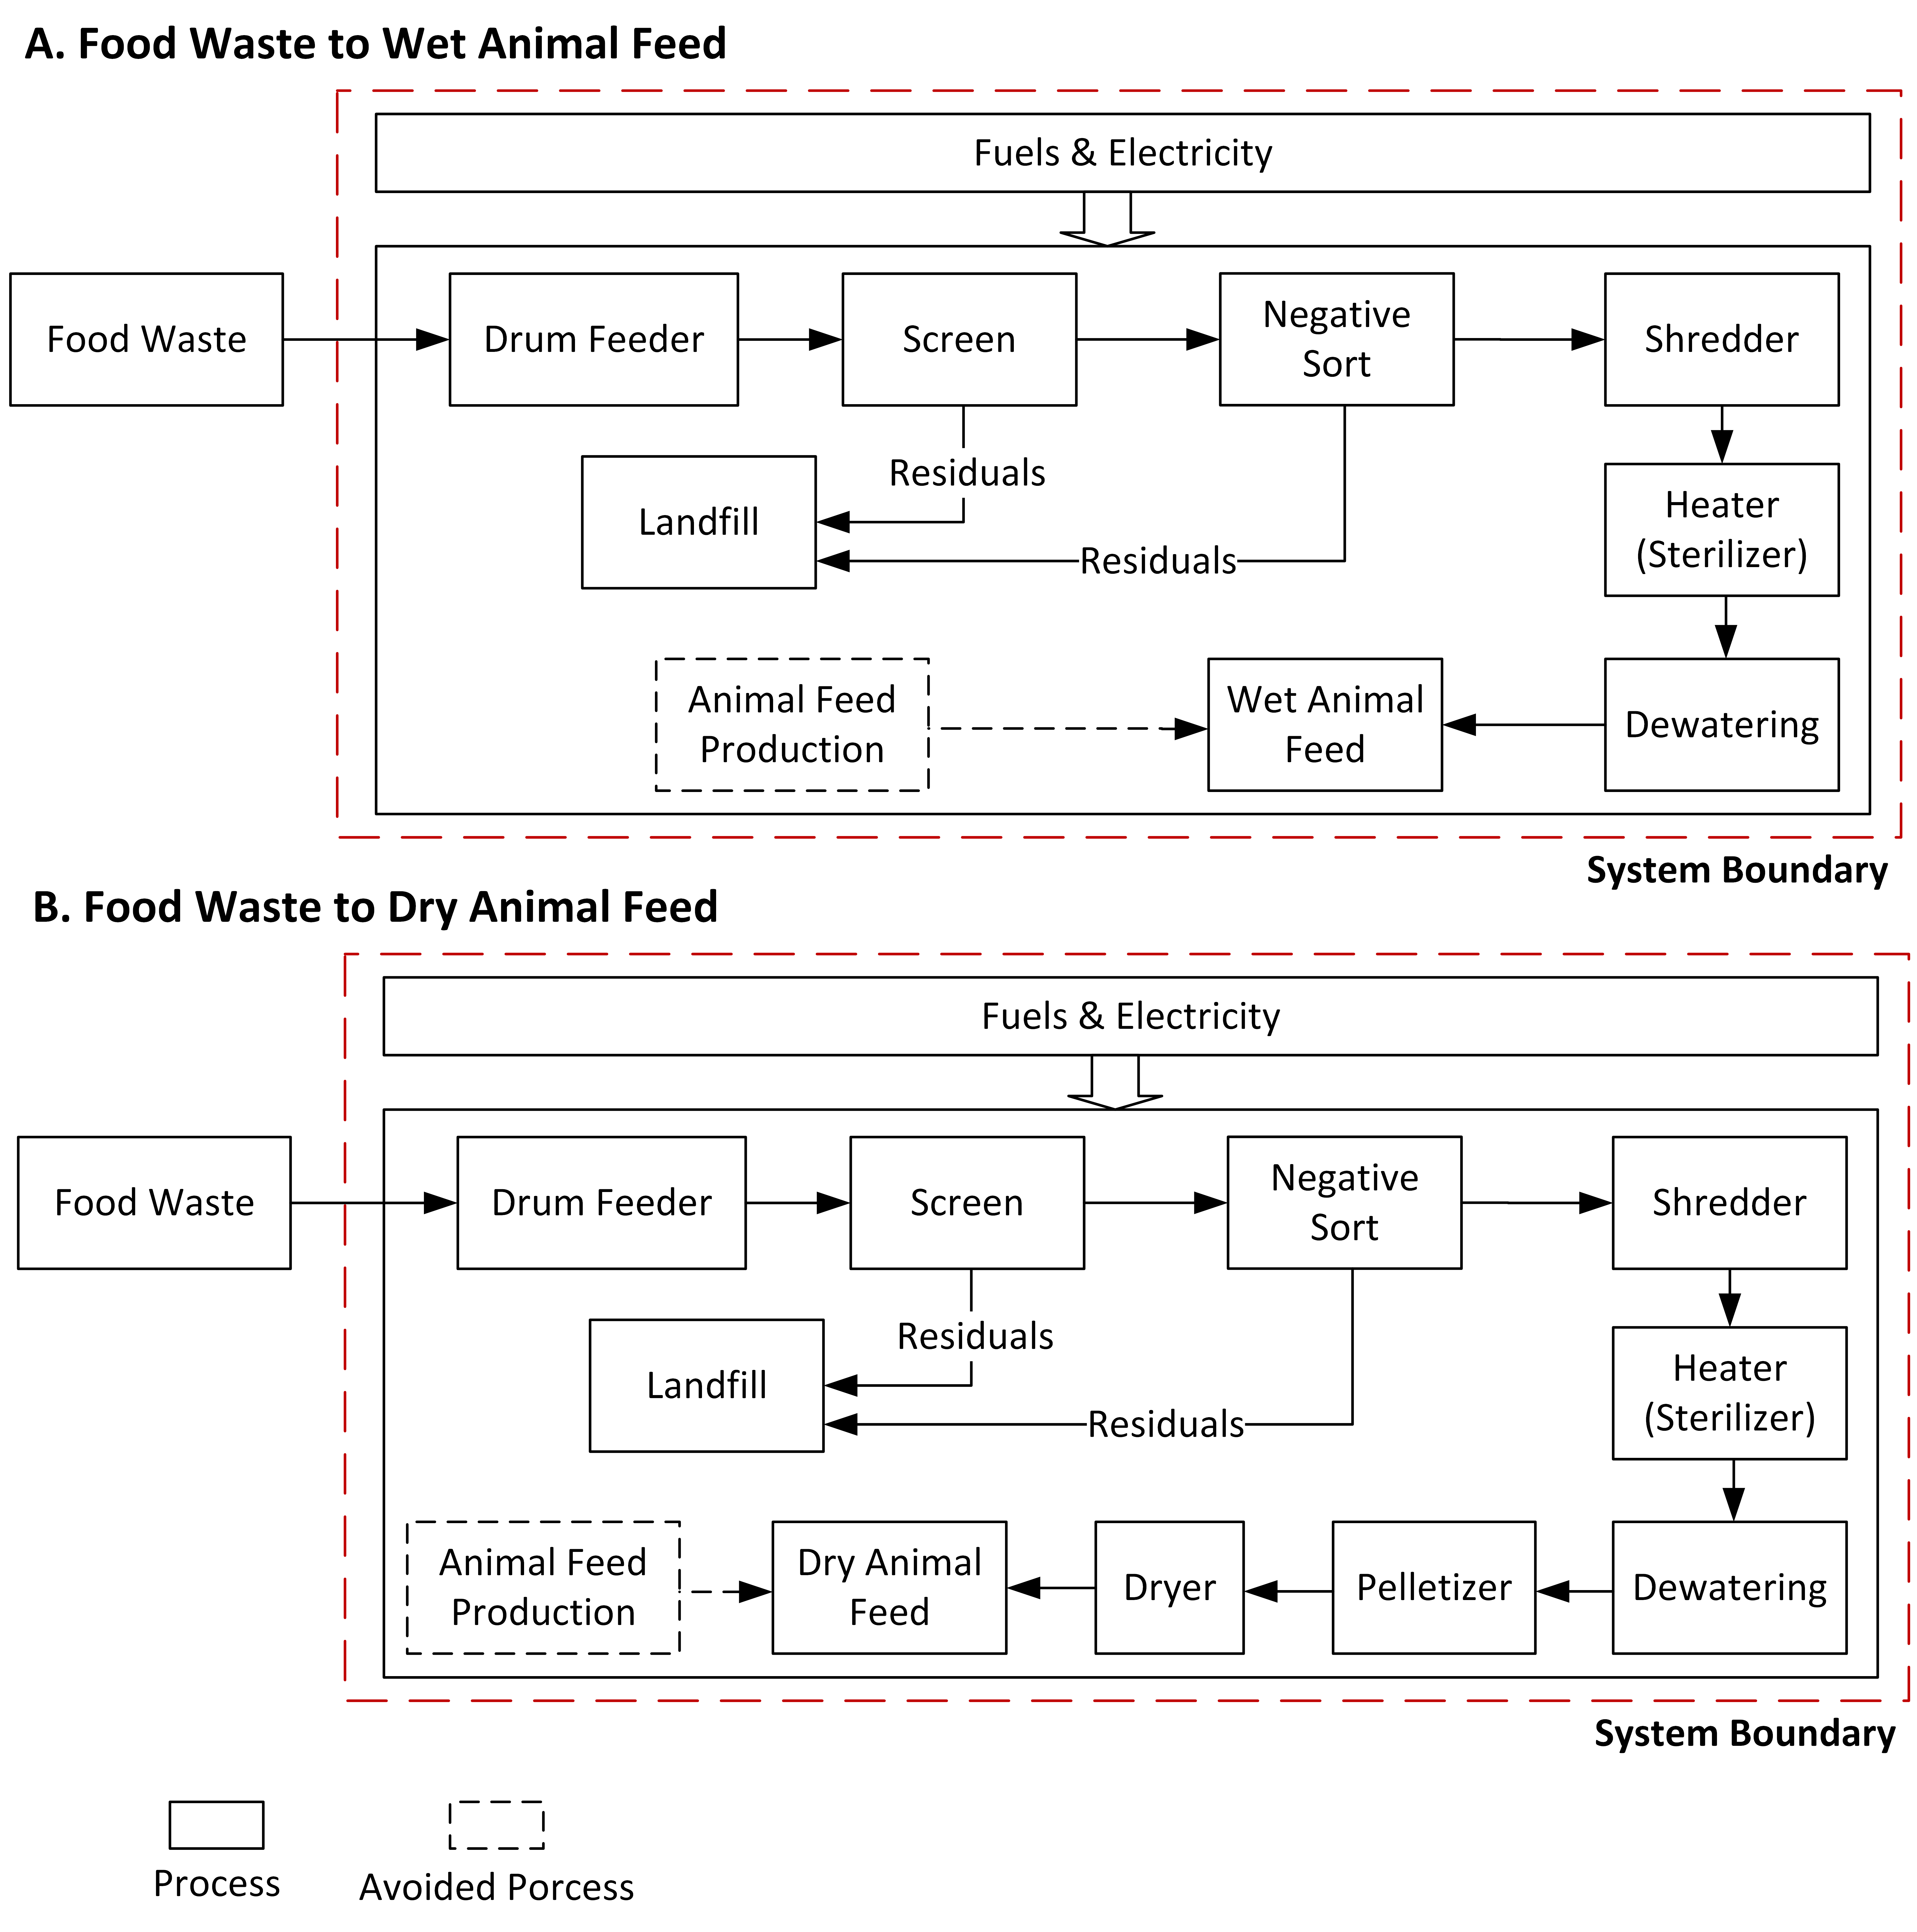

In [4]:
Image(filename='Figures/Animal Feed.png', width=700)

## Equipment inputdata

In [5]:
index = ['Calc_base', 'Max_input', 'frac_MaxInput', 'frac_motor', 'motor',
         'diesel_use', 'LPG_use', 'Investment_cost', 'Installation_cost', 'O&M',
         'N_Labor', 'N_Driver', 'LifeTime']
unit = ['0/1/2 (Rmvd/Rmnd/Tot)', 'Mg/hr', 'frac', 'frac', 'kW',
        'L/Mg', 'm3/Mg', '$', '$', '$/yr',
        'person', 'person', 'yr']
equipments_data = pd.DataFrame(index=index)
equipments_data['Unit'] = unit
equipments_data['Drum Feeder'] = pd.DataFrame(input_data.Eq_DFeeder).T['amount']
equipments_data['Disc Screen'] = pd.DataFrame(input_data.Eq_DS).T['amount']
equipments_data['Negative Sort'] = pd.DataFrame(input_data.Eq_Neg_Sort).T['amount']
equipments_data['Shredder'] = pd.DataFrame(input_data.Eq_Shred).T['amount']
equipments_data['Sterilizer'] = pd.DataFrame(input_data.Eq_Sterilizer).T['amount']
equipments_data['Dewater'] = pd.DataFrame(input_data.Eq_Dewater).T['amount']
equipments_data['Dryer'] = pd.DataFrame(input_data.Eq_Dryer).T['amount']
equipments_data['Pelletizer'] = pd.DataFrame(input_data.Eq_Pellet).T['amount']
equipments_data['Conveyor'] = pd.DataFrame(input_data.Eq_Conveyor).T['amount']

for i in ['Drum Feeder', 'Disc Screen', 'Negative Sort', 'Shredder',
          'Sterilizer', 'Dewater', 'Dryer', 'Pelletizer', 'Conveyor']:
    total_throughput = equipments_data.loc['Max_input', i] * equipments_data.loc['frac_MaxInput', i]
    equipments_data.loc['Elec', i] =  round(
        (equipments_data.loc['motor', i] * equipments_data.loc['frac_motor', i])
        / total_throughput, 2)
    

    
    LaborReq = equipments_data.loc['N_Labor', i] / total_throughput
    DriverReq = equipments_data.loc['N_Driver', i] / total_throughput
    LaborCost = (
        (LaborReq * input_data.Labor['Labor_rate']['amount']
         + DriverReq * input_data.Labor['Driver_rate']['amount'])
        * (1 + input_data.Labor['Fringe_rate']['amount'])
        * (1 + input_data.Labor['Management_rate']['amount']))
    equipments_data.loc['Labor Cost', i] = round(LaborCost, 2)

    Cap = equipments_data.loc['Investment_cost', i] + equipments_data.loc['Installation_cost', i]
    Rate = input_data.Constr_cost['Interest_rate']['amount']
    Lftime = equipments_data.loc['LifeTime', i]
    TotalHour = (
        input_data.Labor['Hr_shift']['amount']
        * input_data.Labor['Shift_day']['amount']
        * input_data.Labor['Day_year']['amount'])
    # Average Cost of Ownership ($/Mg)
    AveCostOwner = (
        (npf.pmt(Rate, Lftime, -Cap) + equipments_data.loc['O&M', i])
        / (TotalHour * equipments_data.loc['Max_input', i] * equipments_data.loc['frac_MaxInput', i]))
    equipments_data.loc['Ave Cost Owner', i] = round(AveCostOwner, 2)

equipments_data.loc['Elec', 'Unit'] = 'kWh/Mg'
equipments_data.loc['Labor Cost', 'Unit'] = '$/Mg'
equipments_data.loc['Ave Cost Owner', 'Unit'] = '$/Mg'

    
equipments_data

,Unit,Drum Feeder,Disc Screen,Negative Sort,Shredder,Sterilizer,Dewater,Dryer,Pelletizer,Conveyor
Calc_base,0/1/2 (Rmvd/Rmnd/Tot),2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
Max_input,Mg/hr,30.0,45.0,30.0,30.0,10.0,25.0,12.0,8.0,30.0
frac_MaxInput,frac,1.0,0.85,0.85,0.85,0.85,0.85,0.85,0.85,0.85
frac_motor,frac,0.5,0.5,0.5,0.85,0.85,0.85,0.85,0.85,0.5
motor,kW,15.0,8.5,3.0,320.0,4.0,7.0,100.0,60.0,5.6
diesel_use,L/Mg,0.0,0.0,0.0,0.0,4.5,0.0,24.0,0.0,0.0
LPG_use,m3/Mg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Investment_cost,$,150000.0,175000.0,50000.0,150000.0,60000.0,40000.0,350000.0,30000.0,46258.0
Installation_cost,$,15000.0,17500.0,5000.0,15000.0,6000.0,4000.0,35000.0,2500.0,4625.8
O&M,$/yr,5000.0,10000.0,5000.0,5000.0,5000.0,5000.0,10000.0,5000.0,10000.0


In [6]:
model = AnF()
model.InputData.AnF_operation['isDried']['amount'] = 0
model.InputData.Wastewater['BOD_conc']['amount'] = 0
model.calc()

#### Wastewater treatment impacts

In [7]:
print(f"""
Total Wastewater: {round(model._waste_water.sum()*1000)} L
BOD removal elec: {round(model._BOD_elec.sum())} kWh
BOD removal CO2: {round(model._BOD_CO2.sum())} kg CO2""")


Total Wastewater: 465 L
BOD removal elec: 0 kWh
BOD removal CO2: 0 kg CO2


### LCI Wet Feed

In [8]:
model = AnF()
model.InputData.AnF_operation['isDried']['amount'] = 0
model.InputData.Wastewater['BOD_conc']['amount'] = 0
model.calc()
model.LCI.report(input_mass=model._Input).loc[['Food_Waste_Vegetable', 'Food_Waste_Non_Vegetable'], :]

,"(Technosphere, Electricity_consumption)","(Technosphere, Equipment_Diesel)","(Technosphere, Equipment_LPG)","(biosphere3, Operational_Cost)",Other_Residual,"(Technosphere, Feed_Production)",Bio-CO2 emissions from wastewater treatment,"(biosphere3, Capital_Cost)"
Food_Waste_Vegetable,12.62,4.27,0.0,8.83,0.05,-239.71,0.0,9.66
Food_Waste_Non_Vegetable,12.64,4.27,0.0,8.85,0.05,-324.77,0.0,9.66


### LCI Dry Feed

In [9]:
model = AnF()
model.InputData.AnF_operation['isDried']['amount'] = 1
model.InputData.Wastewater['BOD_conc']['amount'] = 0
model.calc()
model.LCI.report(input_mass=model._Input).loc[['Food_Waste_Vegetable', 'Food_Waste_Non_Vegetable'], :]

,"(Technosphere, Electricity_consumption)","(Technosphere, Equipment_Diesel)","(Technosphere, Equipment_LPG)","(biosphere3, Operational_Cost)",Other_Residual,"(Technosphere, Feed_Production)",Bio-CO2 emissions from wastewater treatment,"(biosphere3, Capital_Cost)"
Food_Waste_Vegetable,19.23,14.17,0.0,9.53,0.05,-239.71,0.0,9.66
Food_Waste_Non_Vegetable,21.59,17.68,0.0,9.79,0.05,-324.77,0.0,9.66


### Results from Literature
| Type | Electricity (kWh/Mg) | Diesel (L/Mg) | Cost (USD/ton) |
| :- | :-  | :-  | :-  |
| Wet Feed | 3.86 | 2.91 | 59.31| 
| Dry Feed | 24.6 | 17.8 (30.8 L LNG) |  72.14 |


**Differences in assumptions**:

* Kim et al. assumed that moisture content of wet feed is 69%.
    * **SwolfPy**:
        * *Moisture content of the incoming food waste is in rage 70 - 78%*
        * *SwolfPy assumption: Moisture contet of the feed after dewatering is 50%*
            * Equipment data: Moisture content of ouput from dewatering is in range **(30 - 40%)**
* SwolfPy calculates higher electricity conumption for wet feed becauese of **shredder**.
* Kim et al. assumed that additives (corn) are added to wet feed.
    * Assuming that additives can replace animal feed based on mass and have same environmental impacts, we didn't include additives.
* Animal feed price:
    * Kim at at.: **0.26 USD/kg**
    * SwolfPy: **0.14 USD/kg**
* Kim at al.: Concentration of BOD in wastewater is **75,000 mg/L** !! **This has a big impact on electricity consumption**
    * In AD model, concentration of BOD in digestate is **2300 mg/L**


**Limitatoins**:
* Cost and environmental impacts of wastewater treatment and sludge.
* Substituion should be based on caloric value and in consideraton of contaminationa/quality
 

**References:**
* Kim, M.-H. and J.-W. Kim. 2010. Comparison through a LCA evaluation analysis of food waste disposal options from the perspective of global warming and resource recovery. Science of The Total Environment 408(19): 3998–4006. https://linkinghub.elsevier.com/retrieve/pii/S0048969710004456. Accessed December 1, 2021.

* Kim, M.-H., Y.-E. Song, H.-B. Song, J.-W. Kim, and S.-J. Hwang. 2011. Evaluation of food waste disposal options by LCC analysis from the perspective of global warming: Jungnang case, South Korea. Waste Management 31(9–10): 2112–2120. https://linkinghub.elsevier.com/retrieve/pii/S0956053X11002170. Accessed December 1, 2021.


